Title: Boardgame Collection Similarity Analysis <br>
Author: Austin Chou <br>
Date: 2018-11-07

# Purpose

The intent of this exercise is to:<br>

1) Practice programming and data manipulation in python <br>
2) Perform analysis on a topic of interest<br>
3) Learn some data science techniques

# Problem

There are a variety of methods for building recommendation engines. I want to apply approaches for boardgames which is a personal hobby.

The website "https://boardgamegeek.com/" has over 10000 ranked boardgames (includes expansions and variations of the same base boardgame). For new boardgame collectors and hobbyists, the number of choices is quite astronomical. Even if we reduce look at just the games released in the 2017, there are over 3000 boardgames.

Thus the primary problem is to identify patterns to help recommend boardgames to people who are looking to grow their boardgame collection.  

# Parameters

Boardgames can be defined in many different ways. To keep analysis simple to start, I focus on two different parameters: <br>

1) Mechanisms - primary playstyle of a game (e.g. Roll and Move, Storytelling, Area Control, etc)  <br>
2) Categories - thematic elements of a game (e.g. Adventure, Age of Reason, Bluffing, Zombies, etc)

# Hypothesis

My primary hypothesis: most hobbyists starting out (< 50 games) look to grow their collection by buying <b>DISSIMILAR</b> games. For example, if you already own an Area Control game, you are more likely to buy a game with a different mechanic next.

The underlying reasoning would be - at least among the gamers I've spoken with as well as myself - that people tend to want to have games for every occassion (at least early on). If your friends aren't in the mood for a Bluffing, Deduction game that night, you don't want to only have games of Bluffing, Deduction games on hand.

Of course, there are niche collectors (e.g. those who collect the many different versions of Monopoly or Pandemic). And naturally, not every Category or Mechanisms will resonate and each gamer certainly develop their own preferences and curate their collection accordingly. It will be interesting to see if I can identify to what degree my initial hypothesis holds true.

# Approach

1) Obtain the list of boardgames available on boardgamegeek <br>
-I will initially limit the analysis to ranked boardgames only.

2) Obtain the Categories and Mechanisms associated with each game individually

3) Obtain a dataset of user collections of varying sizes

4) Create a metric for boardgame Similarity based on Categories and Mechanics and apply that to user collections

5) Implement a NLP approach to boardgame recommendation

## Load appropriate functions, packages, and parameters

In [1]:
# Load in functions
%run functions-bgg_get.py

# General libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# For webscraping
from bs4 import BeautifulSoup
import requests
from time import time, sleep

# Regular expression
import re

# Flags to rerun code chunks
recollect = False
reclean = False

# Collect Mechanisms, Categories, and Boardgame list

We want to collect the following data:

1) List of all Mechanisms used by bgg

2) List of all Categories used by bgg

3) List of all ranked games listed on bgg. We will also grab the Rank and ID of the game on bgg.

4) Compile a master list which details each game's Name, Rank, ID, #Players (player count), Playtime, Weight, Categories, Mechanisms, Total Categories, and Total Mechanics. This results in the following columns:<br>
-Game name <br>
-Game rank <br>
-Game ID <br>
-#players <br>
-playtime <br>
-Weight <br>
-84 categories (each a unique column) <br>
-51 mechanisms (eacn a unique column)<br>
-total categories <br>
-total mechanics

The collection script takes several hours to finish due to the fact that collecting several thousand game information is fairly slow.

In [96]:
if recollect:
    %run script-collect_bgg_parameters.py

In [102]:
# Show what the collected dataframe looks like
ga = pd.read_csv('bgg game attributes.csv', header=1)
ga.drop(ga.columns[0], inplace=True, axis=1)
ga.head()

2018-10-20 20:04:49 [py.warnings] WARNING: C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



,Game name,Game rank,Game ID,#players,playtime,weight,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,...,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement,total categories,total mechanics
0,Pandemic Legacy: Season 1,1.0,161936.0,4.0,60.0,2.810298,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0
1,Through the Ages: A New Story of Civilization,2.0,182028.0,4.0,240.0,4.360444,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
2,Twilight Struggle,3.0,12333.0,2.0,180.0,3.546351,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
3,Gloomhaven,4.0,174430.0,4.0,120.0,3.783154,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,9.0
4,Star Wars: Rebellion,5.0,187645.0,4.0,240.0,3.614251,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,6.0


# Cleaning game_attributes dataset

1) We should assume that any game without categories or mechanics can be removed.

2) Noticed that if the # of categories or mechanics exceeded 6, the script doesn't "see" the extra categories/mechanics. We need to manually adjust the binary categories/mechanics for games with >6 categories/mechanics. We can identify these as a separate list and go through it manually.

The cleaning script outputs two csvs:

1) A csv for every entry matching the criteria ">6 categories/mechanics". These entries will need to be manually checked to add missing Categories or Mechanisms: bgg_games_for_manual.csv

2) A csv for the cleaned dataset (without having accounted for manual adjustments): bgg_games_curated.csv

In [103]:
if reclean:
    %run script-clean_game_attributes.py

# Boardgame Similarity

Let's approach determining a metric of boardgame similarity through a few approaches. We can use direct euclidean distance where every column of a game is a variable or we can perform some sort of dimensionality reduction. In any case, scaling the non-binary columns is necessary.

## Scaling the data

In [12]:
# Load csv of games after manually adjusting mechanisms and categories as
#  mentioned in "Cleaning game_attributes dataset"
ga = pd.read_csv('bgg game attributes edited.csv', header = 1)
ga.drop(ga.columns[0], inplace=True, axis=1)

scaled_ga = scale_dataframe(ga)

In [13]:
# Number of total columns (features)
len(scaled_ga.columns)

138

In [14]:
scaled_ga.head()

,#players,playtime,weight,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,...,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,-0.088568,-0.048679,0.943120,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,-0.088568,0.241604,2.833330,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.207549,0.144843,1.840645,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.088568,0.048082,2.129397,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-0.088568,0.241604,1.923440,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## PCA

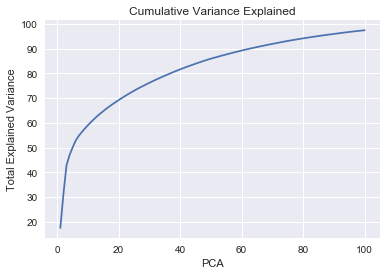

In [34]:
# Import sklearn PCA
from sklearn.decomposition import PCA
#Apply PCA
pca = PCA()
ga_pca = pca.fit_transform(scaled_ga)

#Check what % variance is explained by each component
var_ex = pca.explained_variance_ratio_ * 100
var_cum = np.cumsum(var_ex[0:100])

plt.plot(np.arange(1,len(var_cum)+1),var_cum)
plt.xlabel('PCA')
plt.ylabel('Total Explained Variance')
plt.title('Cumulative Variance Explained')
print()

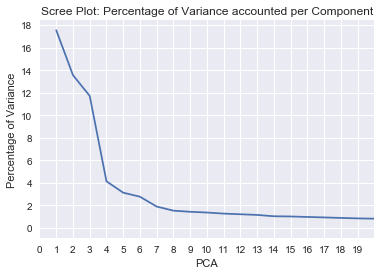

In [44]:
plt.plot(np.arange(1,len(var_ex)+1),var_ex)
plt.xlabel('PCA')
plt.ylabel('Percentage of Variance')
plt.title('Scree Plot: Percentage of Variance accounted per Component')
plt.xticks(np.arange(0,20,step=1))
plt.yticks(np.arange(0,20,step=2))
plt.xlim(0,20)
print()

In [161]:
#Take top 40 Components (explains 80% Variance)
pca = PCA(n_components=40)
ga_pca = pca.fit_transform(scaled_ga)

principal_DF = pd.DataFrame(data = ga_pca,
                           columns = range(1,ga_pca.shape[1]+1))
principal_DF = pd.concat([ga['Game name'], principal_DF],
                        axis = 1)

In [163]:
principal_DF.to_csv("game_pcas.csv")
principal_DF.head()

,Game name,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,Pandemic Legacy: Season 1,0.673281,-0.107975,-0.525156,0.829340,0.357668,0.329506,0.201970,-0.103046,0.636939,...,-0.040856,0.444143,0.395092,0.265071,-0.474946,0.223306,0.113626,-0.436538,0.256870,-0.056518
1,Through the Ages: A New Story of Civilization,2.204392,0.073917,-1.306654,1.342125,-0.288161,0.626087,0.571806,-0.500239,-0.654098,...,0.116902,0.200929,0.216272,0.179287,0.156545,-0.286241,0.129852,-0.200346,0.003521,0.051991
2,Twilight Struggle,1.765369,-0.110046,-0.992784,0.229033,0.283644,-0.437713,0.393482,0.720139,-0.206650,...,-0.595500,0.008888,0.031304,0.002625,-0.278776,-0.258241,-0.083805,0.097510,-0.120890,0.121969
3,Gloomhaven,1.699216,-0.041316,-1.211693,1.215590,1.474759,0.290139,-1.508938,-0.318001,0.831645,...,-0.434315,0.035489,-0.079435,-0.348697,-0.246134,-0.251111,0.096047,0.682758,-0.113878,0.135615
4,Star Wars: Rebellion,1.902260,0.040830,-1.083778,0.402472,1.233334,-0.474276,-0.332234,0.165811,-0.095705,...,-0.077234,-0.474748,-0.326718,-0.285475,-0.100502,0.124752,0.244741,-0.078449,-0.346046,0.433381


We only explain about 50% of the variance in the first 5-10 PCs. Only 70% explained in the first 20 PCs. 80% explained variance is achieved at around 40 PCs.

For further analysis, let's start with accounting for 80% of the data variance. This gives us 40 PCAs.

Note for alternate approaches: use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions further.
 
 https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

# Game Clustering

Using the PCA-derived coordinates, I wanted to try clustering the games. We can adjust the number of clusters. With 40 PCAs and 10000+ games, I went with 40 clusters to start.

In [253]:
from sklearn.cluster import KMeans
# Get dataset and separate out a dataframe with just the PCA values
ga_pca = pd.read_csv("game_pcas.csv",sep = ",",encoding='ISO-8859-1')
ga_pca.drop(ga_pca.columns[0], inplace = True, axis = 1)
ga_pca_coord = ga_pca.drop("Game name", inplace = False, axis = 1)

# Run KMeans from sklearn
kmeans = KMeans(n_clusters = 40)
kmeans.fit(ga_pca_coord)

# Add on the labels
ga_pca['Group'] = kmeans.labels_
ga_pca.to_csv("game_pcas_grouped.csv")

In [254]:
ga_pca.head()

,Game name,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,Group
0,Pandemic Legacy: Season 1,0.673281,-0.107975,-0.525156,0.829340,0.357668,0.329506,0.201970,-0.103046,0.636939,...,0.444143,0.395092,0.265071,-0.474946,0.223306,0.113626,-0.436538,0.256870,-0.056518,19
1,Through the Ages: A New Story of Civilization,2.204392,0.073917,-1.306654,1.342125,-0.288161,0.626087,0.571806,-0.500239,-0.654098,...,0.200929,0.216272,0.179287,0.156545,-0.286241,0.129852,-0.200346,0.003521,0.051991,0
2,Twilight Struggle,1.765369,-0.110046,-0.992784,0.229033,0.283644,-0.437713,0.393482,0.720139,-0.206650,...,0.008888,0.031304,0.002625,-0.278776,-0.258241,-0.083805,0.097510,-0.120890,0.121969,0
3,Gloomhaven,1.699216,-0.041316,-1.211693,1.215590,1.474759,0.290139,-1.508938,-0.318001,0.831645,...,0.035489,-0.079435,-0.348697,-0.246134,-0.251111,0.096047,0.682758,-0.113878,0.135615,29
4,Star Wars: Rebellion,1.902260,0.040830,-1.083778,0.402472,1.233334,-0.474276,-0.332234,0.165811,-0.095705,...,-0.474748,-0.326718,-0.285475,-0.100502,0.124752,0.244741,-0.078449,-0.346046,0.433381,31


## TSNE

T-SNE is a visualization technique for reducing multi-parameter datasets into a 2D space. Even though it is inaccurate for determining true distance between points, I think it could be informative as a qualitative gauge of Similarity: extremely similar games should always cluster close to each other.


Reading over T-SNE, it seems that perplexity and steps (n-iter) are parameters that can be adjusted to make sure the t-sne algorithm is performing well and not generating unexpected clusters. After some testing, I settled on Perplexity of 100 with 2000 steps.

I ran T-SNE, which took a while, and saved the coordinates to reproducible the same plot in the future.

For this initial run, I decided to check the accuracy of the idea that Similar games should cluster closely in TSNE space. I did this with the non-PCA adjusted dataset.

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities

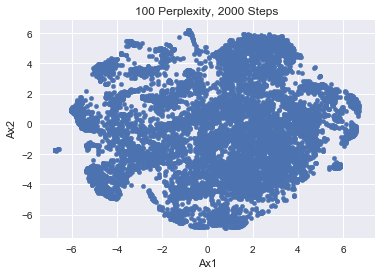

In [146]:
# Import t-sne
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=2000)
# tsne_results = tsne.fit_transform(scaled_ga)
# tsne_coord = pd.concat([ga['Game name'],
#                         pd.DataFrame(tsne_results, columns=['Ax1','Ax2'])],
#                        axis=1)

# # See the t-sne plot
# ts= tsne_coord.plot(x='Ax1',y='Ax2',kind='scatter',title='Perplexity 50')
tsne_coord = game_tsne(original_ga = ga, 
                       scaled_ga = scaled_ga,
                       perp = 100,
                       steps = 2000)

# Closest and furthest games: comparing T-SNE space and PCA space

As a proof of concept, let's look at the closest games to a well known game: "Monopoly".

We would expect that the closest game to Monopoly should be other Monopoly types. For comparison, we'll also see what the closest games were using the PCA space too.

In [12]:
# Get tsne dataset
ga_tsne = pd.read_csv('bgg tsne coordinates 100Perplexity 2000Steps.csv')
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)

find_closest_game('Monopoly', game_coordinates = ga_tsne, n = 10)

,Game name,Dissimilarity/Distance
0,Monopoly: X-Men,0.000838
1,Monopoly: Marvel Comics,0.001518
2,Monopoly: Electronic Banking,0.001806
3,Monopoly: Tropical Tycoon DVD Game,0.002035
4,Monopoly: Nintendo,0.004181
5,Monopoly: Nintendo Collector's Edition,0.004306
6,Monopoly: The Beatles Collector's Edition,0.005050
7,Superpoly,0.005421
8,Monopoly: Here & Now Electronic Banking,0.005429
9,Monopoly: Spider-Man,0.005440


In [13]:
# Get PCA dataset
ga_pca = pd.read_csv("game_pcas_grouped.csv", encoding='ISO-8859-1')
ga_pca.drop(ga_pca.columns[0], inplace = True, axis = 1)

find_closest_game(game = "Monopoly", game_coordinates = ga_pca, n = 10)

,Game name,Dissimilarity/Distance
0,Monopoly: The Portable Property Trading Game,0.244350
1,Monopoly: National Parks Edition,0.260173
2,Monopoly: Australian Edition,0.346960
3,Monopoly: Here and Now,0.353144
4,Monopoly: 1935 Deluxe,0.356777
5,Monopoly: Nintendo Collector's Edition,0.375269
6,Monopoly: London,0.381756
7,Monopoly: Millennium,0.393153
8,Monopoly: The Beatles Collector's Edition,0.396721
9,Cat-opoly,0.414985


If we look at Ticket to Ride or Pandemic - both of which also have a large number of variants - we observe close clustering of their variants

In [21]:
print("\nT-SNE coordinates/Dissimilarity")
print(find_closest_game('Ticket to Ride', game_coordinates = ga_tsne, n = 5))
print("\nPCA coordinates/Distance")
print(find_closest_game('Ticket to Ride', game_coordinates = ga_pca, n = 5))


T-SNE coordinates/Dissimilarity
                          Game name  Dissimilarity/Distance
0            Ticket to Ride: Europe                0.011219
1  Ticket to Ride: Nordic Countries                0.058954
2                   Thurn and Taxis                0.065560
3           Ticket to Ride: Germany                0.070720
4           Zug um Zug: Deutschland                0.073247

PCA coordinates/Distance
                          Game name  Dissimilarity/Distance
0            Ticket to Ride: Europe                0.108594
1  Ticket to Ride: Nordic Countries                0.428039
2           Zug um Zug: Deutschland                0.991096
3           Ticket to Ride: Germany                0.998558
4                        Yardmaster                1.280012


In [22]:
print("\nT-SNE coordinates/Dissimilarity")
print(find_closest_game('Pandemic', game_coordinates = ga_tsne, n = 5))
print("\nPCA coordinates/Distance")
print(find_closest_game('Pandemic', game_coordinates = ga_pca, n = 5))


T-SNE coordinates/Dissimilarity
                    Game name  Dissimilarity/Distance
0             Pandemic Iberia                0.028966
1   Pandemic Legacy: Season 1                0.082755
2  Pandemic: Reign of Cthulhu                0.092547
3  Dragon Keeper: The Dungeon                0.097617
4      Ticket to Ride: Europe                0.100043

PCA coordinates/Distance
                    Game name  Dissimilarity/Distance
0             Pandemic Iberia                0.333399
1   Pandemic Legacy: Season 1                0.475057
2  Pandemic: Reign of Cthulhu                0.507780
3             Kings of Israel                0.756559
4   Pandemic Legacy: Season 2                1.609790


### T-SNE distance does not capture true distance

T-SNE does not retain distances, so while it retains information about density and clustering, it would be extremely poor for finding games that are MOST dissimilar. Which is to say:<br>
1) A low Dissimilarity score can be an estimate of how similar games are (as T-SNE tries to keep clustering patterns), but <br>
2) A high Dissimilarity score does provide precise information about just how different games are.

I wrote a function to find games furthest from each other as practice and also to show that while we get similar outputs using t-sne coordinates and pca coordinates for Find Closest Game, we get pretty different results for Find Furthest Games.

In [25]:
print("\nT-SNE coordinates/Dissimilarity")
find_furthest_game('Pandemic', game_coordinates = ga_tsne, k=10)


T-SNE coordinates/Dissimilarity


,Game name,Dissimilarity/Distance
0,Linkee,8.661021
1,Alchemidus,8.658250
2,Act One,8.656587
3,Martian Dice,8.656459
4,Rolling Japan,8.656183
5,Rolling America,8.656146
6,Micro Robots,8.656085
7,Zombie Dice,8.656079
8,Streams,8.656070
9,Picture Pursuit,8.656070


In [24]:
print("\nPCA coordinates/Distance")
find_furthest_game('Pandemic', game_coordinates=ga_pca, k=10)


PCA coordinates/Distance


,Game name,Dissimilarity/Distance
0,The Campaign for North Africa,98.261140
1,Start Player: A Kinda Collectible Card Game,61.158795
2,Scrimish Card Game,61.152016
3,"I Don't Know, What Do You Want To Play?",61.146611
4,Case Blue,38.382256
5,1914: Offensive à outrance,30.471514
6,Atlantic Wall: D-Day to Falaise,26.416199
7,Empires in Arms,23.079860
8,Drang Nach Osten!,23.065506
9,The Hammer of Thor: The Game of Norse Mythology,21.556767


## TSNE with PCA dataset and Clusters

With the results of the K means clustering, I reran the TSNE function with the PCA dataset. Then I mapped on the assigned grouping to see how the clusters map on to the TSNE space; could we identify distinct clusters?

In [10]:
# Import t-sne
from sklearn.manifold import TSNE
# Get dataset and separate out a dataframe with just the PCA values
ga_pca = pd.read_csv("game_pcas_grouped.csv", encoding='ISO-8859-1')
ga_pca.drop(ga_pca.columns[0], inplace = True, axis = 1)
ga_pca_coord = ga_pca.drop(["Game name", "Group"], inplace = False, axis = 1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities 

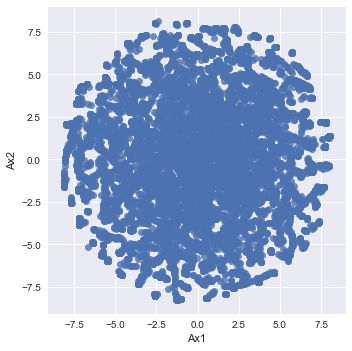

In [12]:
ga_pca = pd.read_csv("game_pcas_grouped.csv", encoding='ISO-8859-1')
ga_pca.drop(ga_pca.columns[0], inplace = True, axis = 1)
ga_pca_coord = ga_pca.drop(["Game name", "Group"], inplace = False, axis = 1)

# Run the t-sne function
tsne_coord = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 10,
                       steps = 1000000)
tsne_coord['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities 

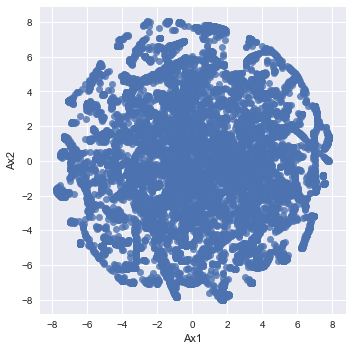

In [13]:
# Run the t-sne function
tsne_coord20 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 20,
                       steps = 1000000)
tsne_coord20['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord20, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities 

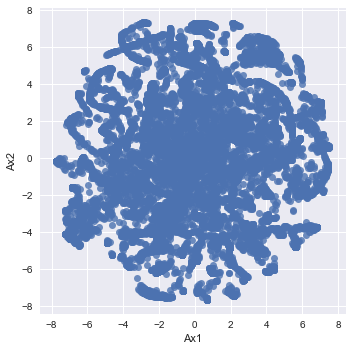

In [14]:
# Run the t-sne function
tsne_coord30 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 30,
                       steps = 1000000)
tsne_coord30['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord30, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities

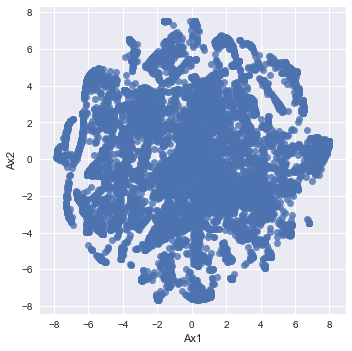

In [15]:
# Run the t-sne function
tsne_coord40 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 40,
                       steps = 1000000)
tsne_coord40['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord40, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities

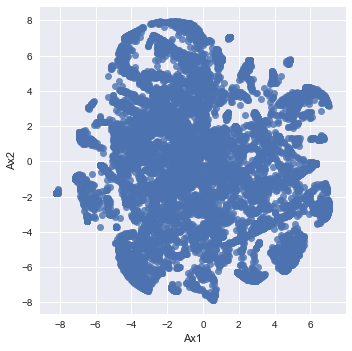

In [16]:
# Run the t-sne function
tsne_coord50 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 50,
                       steps = 1000000)
tsne_coord50['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord50, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities

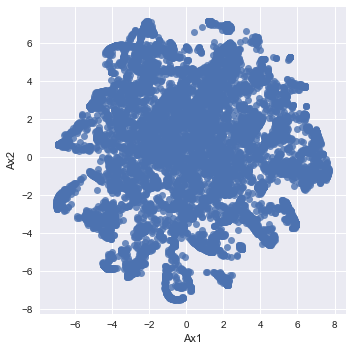

In [17]:
# Run the t-sne function
tsne_coord70 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 70,
                       steps = 1000000)
tsne_coord70['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord70, fit_reg=False)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 13955
[t-SNE] Computed conditional probabilities for sample 2000 / 13955
[t-SNE] Computed conditional probabilities for sample 3000 / 13955
[t-SNE] Computed conditional probabilities for sample 4000 / 13955
[t-SNE] Computed conditional probabilities for sample 5000 / 13955
[t-SNE] Computed conditional probabilities for sample 6000 / 13955
[t-SNE] Computed conditional probabilities for sample 7000 / 13955
[t-SNE] Computed conditional probabilities for sample 8000 / 13955
[t-SNE] Computed conditional probabilities for sample 9000 / 13955
[t-SNE] Computed conditional probabilities for sample 10000 / 13955
[t-SNE] Computed conditional probabilities for sample 11000 / 13955
[t-SNE] Computed conditional probabilities for sample 12000 / 13955
[t-SNE] Computed conditional probabilities for sample 13000 / 13955
[t-SNE] Computed conditional probabilities

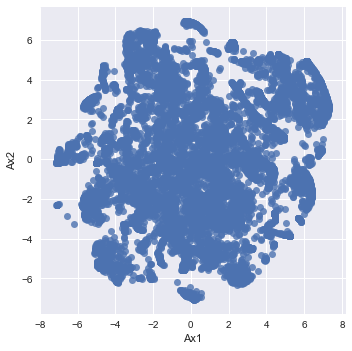

In [18]:
# Run the t-sne function
tsne_coord80 = game_tsne(original_ga = ga_pca, 
                       scaled_ga = ga_pca_coord,
                       perp = 80,
                       steps = 1000000)
tsne_coord80['Group'] = ga_pca['Group']
sns.lmplot(x = 'Ax1', y = 'Ax2', data = tsne_coord80, fit_reg=False)


Looking at the t-sne plots, I went with 50 perplexity. High perplexity can generate false clusters, so I wanted to go with the plot where clustering is noticeable. Noticeably, there are weird, pinched shapes starting at Perplexity 30 and still noticeable at Perplexity 50; I might increase the number of steps further next time.

In [19]:
tsne_coord50.to_csv("games_pca_tsne_grouped.csv")

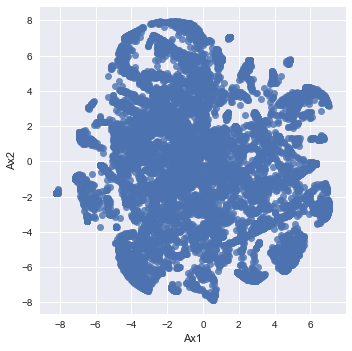

In [20]:
# Load our t-sne generated from our PCA dataset with Groups assigned
ga_tsne_grp = pd.read_csv('games_pca_tsne_grouped.csv', encoding='ISO-8859-1')
sns.lmplot(x = 'Ax1', y = 'Ax2', data = ga_tsne_grp, fit_reg=False)

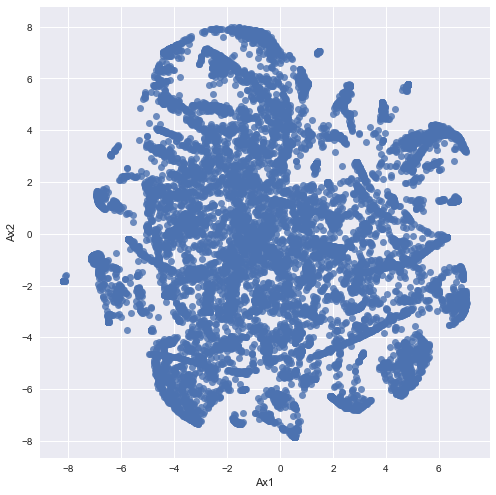

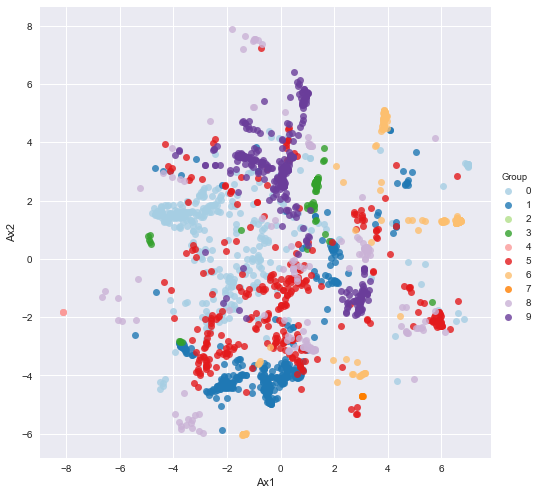

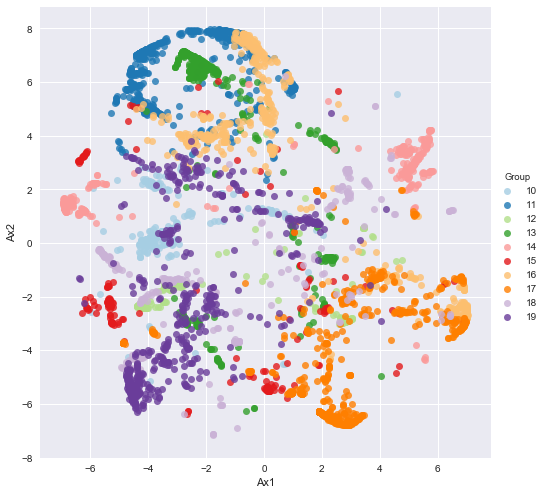

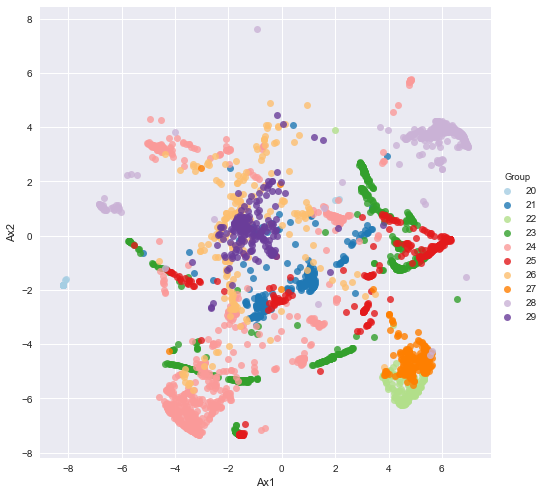

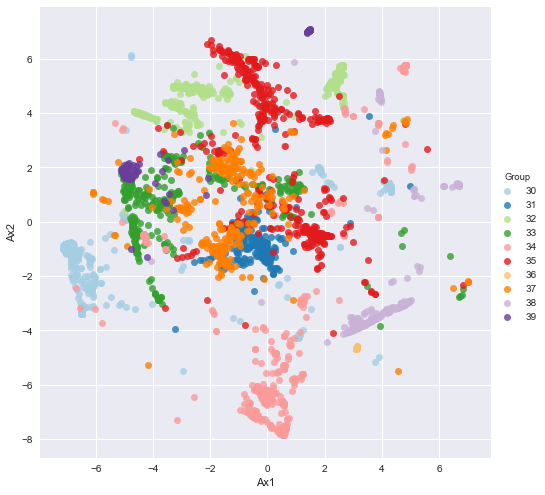

In [21]:
# Load our t-sne generated from our PCA dataset with Groups assigned
ga_tsne_grp = pd.read_csv('games_pca_tsne_grouped.csv', encoding='ISO-8859-1')
p = sns.lmplot(x='Ax1',
               y='Ax2',
               data=ga_tsne_grp, 
               size=7,
               fit_reg=False)

# For visibility, we'll plot 10 groups at a time (since the color palette doesn't work well with 40 groups)
p = sns.lmplot(x='Ax1',
               y='Ax2',
               data=ga_tsne_grp.loc[ga_tsne_grp['Group'].isin(range(0,10))], 
               size=7,
               fit_reg=False,
               hue='Group',
               palette=sns.color_palette("Paired",30))

p = sns.lmplot(x='Ax1',
               y='Ax2',
               data=ga_tsne_grp.loc[ga_tsne_grp['Group'].isin(range(10,20))], 
               size=7,
               fit_reg=False,
               hue='Group',
               palette=sns.color_palette("Paired",30))

p = sns.lmplot(x='Ax1',
               y='Ax2',
               data=ga_tsne_grp.loc[ga_tsne_grp['Group'].isin(range(20,30))], 
               size=7,
               fit_reg=False,
               hue='Group',
               palette=sns.color_palette("Paired",30))

p = sns.lmplot(x='Ax1',
               y='Ax2',
               data=ga_tsne_grp.loc[ga_tsne_grp['Group'].isin(range(30,40))], 
               size=7,
               fit_reg=False,
               hue='Group',
               palette=sns.color_palette("Paired",30))

# Obtain user collections

Not shown here: I obtained user collections via boardgamegeek. I utilized a function that accepted the user id as an input. The output was a dataframe with the following columns:<br>
-User<br>
-Game<br>
-User rating (of the game)<br>
-BGG rating (of the game)

I pulled 211 different collections ranging from 7 to 300 games.

# User Collection distance

Using the tsne points as a representation of "boardgame similarity", we can qualitatively estimate how similar the games in a user's collection are to each other.

1) Load user data

2) Load tsne points

3) Calculate all possible game-pair distances

4) Average each game-pair distance

In [7]:
# Get tsne, use 100 perplexity, 2000 steps file
ga_tsne = pd.read_csv('bgg tsne coordinates 100Perplexity 2000Steps.csv')
#Drop the first column (just indices)
ga_tsne.drop('Unnamed: 0', inplace=True, axis=1)
ga_tsne[['Ax1','Ax2']] = ga_tsne[['Ax1','Ax2']].apply(pd.to_numeric)
ga_tsne.head()

,Game name,Ax1,Ax2
0,Pandemic Legacy: Season 1,1.469032,1.059907
1,Through the Ages: A New Story of Civilization,-0.717615,4.136002
2,Twilight Struggle,-2.007384,-2.909323
3,Gloomhaven,0.901640,2.072781
4,Star Wars: Rebellion,-0.815933,-2.684164


In [31]:
# Get a user list
playerlist = pd.read_excel('playerlist.xlsx')
# Storage dataframe
user_collection_distances = pd.DataFrame(0,
                                         index=np.arange(playerlist.shape[0]),
                                         columns=['User','Avg Dissimilarity'])

for i in np.arange(0,playerlist.shape[0]):
    # Get individual user's collection file
    user = playerlist['Username'][i]
    file = str(user) + '_raw.csv'
    user_collection = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
    user_collection.drop('Unnamed: 0', inplace=True, axis=1)
    
    user_collection_cleaned = RatingThreshold(user_collection)
    user_dist = collection_distance(user_collection_cleaned['Game'], ga_tsne)
    
    user_collection_distances.loc[i, 'User'] = user
    user_collection_distances.loc[i, 'Avg Dissimilarity'] = user_dist

E:\Dropbox\DS\bgg github\Boardgame-Recommender-Project\functions-bgg_get.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  collection.drop(collection.index[low_bgg_idx],inplace=True)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


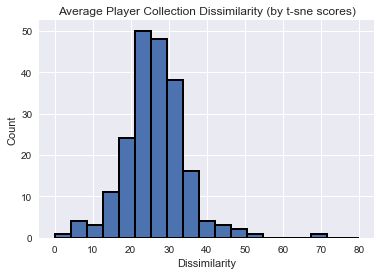

In [32]:
# There are NaN values in our dataset; let's remove them
nan_collections = user_collection_distances[user_collection_distances['Avg Dissimilarity'].isnull()]
clean_collections = user_collection_distances.drop([111,113,114,122,207])

plt.hist(clean_collections['Avg Dissimilarity'].tolist(), 
         bins=np.linspace(0,80,20),
         edgecolor='black',
         linewidth=2.0)
plt.xlabel('Dissimilarity')
plt.ylabel('Count')
plt.title('Average Player Collection Dissimilarity (by t-sne scores)')

For comparison, I took the top 1000 games and calculated the distance between every pair of game. The resulting histogram of distances is as follows:

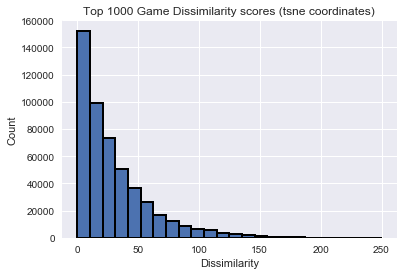

In [188]:
game_dissimilarities = pd.read_csv("Top1000 Game Dissimilarities v2.csv", 
                                   encoding='ISO-8859-1')
game_dissimilarities.drop("Unnamed: 0", inplace=True, axis=1)

plt.hist(game_dissimilarities['Dissimilarity'].tolist(), 
         bins=np.linspace(0,250,25),
         edgecolor='black',
         linewidth=2.0)
plt.xlabel('Dissimilarity')
plt.ylabel('Count')
plt.title('Top 1000 Game Dissimilarity scores (tsne coordinates)')

For comparison, let's see what it would look like if a collector focused only on collecting all Monopoly games (of which there are 113 games).

In [8]:
monopolies = ga_tsne[ga_tsne['Game name'].str.contains("Monopoly")]['Game name']
print('Average collection Dissimilarity for a collection of Monopoly games: ' +
      str(collection_distance(monopolies, ga_tsne)))

Average collection Dissimilarity for a collection of Monopoly games: 11.2593563818


In [107]:
print("For comparison:")
print("Median user collection Dissimilarity score: " +
     str(clean_collections['Avg Dissimilarity'].median()))
print(user_collection_distances['Avg Dissimilarity'].describe())

For comparison:
Median user collection Dissimilarity score: 26.28898190042397
count    206.000000
mean      26.290955
std        8.169616
min        0.178866
25%       21.889913
50%       26.288982
75%       30.493993
max       71.230225
Name: Avg Dissimilarity, dtype: float64


It seems even if we only collected Monopoly games, the Dissimilarity score is quite high (compared to a very left-leaning Dissimilarity distribution). This would further suggest that TSNE is unsuitable for answering our question beyond visualizing the boardgame space. Or alternatively, Monopoly games are more disparate than I first thought.

On the latter point, the average dissimilarity for a Monopoly collection is still left of the mean and median of our User dataset. Thus the original hypothesis - that collectors tend to buy Dissimilar games - is not shown to be false yet.

## A Euclidean approach

Just to test whether a Euclidean distance would produce a different outcome, let's analyze the data without any dimension reduction.

In [46]:
# Load csv of games after manually adjusting mechanisms and categories as
#  mentioned in "Cleaning game_attributes dataset"
ga = pd.read_csv('bgg game attributes edited.csv', header = 1)
ga.drop(ga.columns[0], inplace=True, axis=1)

scaled_ga = scale_dataframe(ga)
scaled_ga = pd.concat([ga['Game name'], scaled_ga], axis = 1)

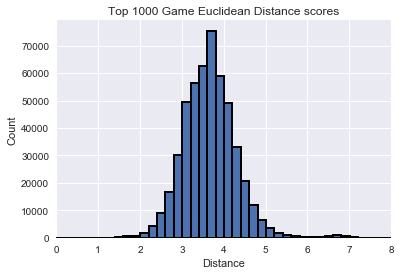

In [55]:
game_distances = pd.read_csv("Top1000 Game Euclidean Distances.csv", 
                             encoding='ISO-8859-1')
game_distances.drop("Unnamed: 0", inplace=True, axis=1)

plt.hist(game_distances['Distance'].tolist(), 
         bins=np.linspace(0,100,500),
         edgecolor='black',
         linewidth=2.0)
plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Top 1000 Game Euclidean Distance scores')
plt.xlim(0,8)
print()

In [58]:
# Get a user list
playerlist = pd.read_excel('playerlist.xlsx')
# Storage dataframe
user_collection_euc_distances = pd.DataFrame(0, 
                                             index=np.arange(playerlist.shape[0]), 
                                             columns=['User','Avg Euc Distance'])

for i in np.arange(0,playerlist.shape[0]):
    # Get individual user's collection file
    user = playerlist['Username'][i]
    file = str(user) + '_raw.csv'
    user_collection = pd.read_csv(file, sep='\t', encoding='ISO-8859-1')
    user_collection.drop('Unnamed: 0', inplace=True, axis=1)
    
    user_collection_cleaned = RatingThreshold(user_collection)
    user_dist = collection_euc_distance(user_collection_cleaned['Game'], scaled_ga)
    
    user_collection_euc_distances.loc[i, 'User'] = user
    user_collection_euc_distances.loc[i, 'Avg Euc Distance'] = user_dist

E:\Dropbox\DS\bgg github\Boardgame-Recommender-Project\functions-bgg_get.py:421: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  collection.drop(collection.index[low_bgg_idx],inplace=True)
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


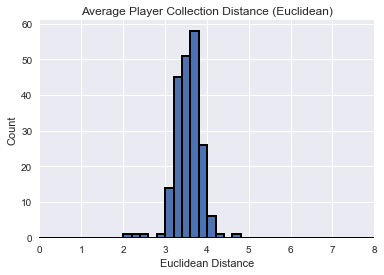

In [59]:
# There are NaN values in our datatable; let's remove them for the histogram
nan_collections = user_collection_euc_distances[user_collection_euc_distances['Avg Euc Distance'].isnull()]
clean_euc_collections = user_collection_euc_distances.drop(nan_collections.index.values)

plt.hist(clean_euc_collections['Avg Euc Distance'].tolist(),
         bins=np.linspace(0,100,500),
         edgecolor='black',
         linewidth=2.0)
plt.xlabel('Euclidean Distance')
plt.ylabel('Count')
plt.title('Average Player Collection Distance (Euclidean)')
plt.xlim(0,8)
print()

In [60]:
print("For comparison:")
print("Median user collection Dissimilarity score: " +
     str(clean_euc_collections['Avg Euc Distance'].median()))
print(user_collection_euc_distances['Avg Euc Distance'].describe())

For comparison:
Median user collection Dissimilarity score: 3.5636919473332274
count    206.000000
mean       3.546142
std        0.296523
min        2.192328
25%        3.370593
50%        3.563692
75%        3.739640
max        4.699306
Name: Avg Euc Distance, dtype: float64


In [62]:
print("For comparison:")
print("Distribution of distances for the Top 1000 Games")
print(game_distances['Distance'].describe())

For comparison:
Distribution of distances for the Top 1000 Games
count    499500.000000
mean          3.707307
std           1.003871
min           0.003016
25%           3.257606
50%           3.638755
75%           4.030536
max          20.821560
Name: Distance, dtype: float64


In [71]:
# Distribution 1 = user collection distribution
mean1 = np.mean(user_collection_euc_distances['Avg Euc Distance'])
std1 = np.std(user_collection_euc_distances['Avg Euc Distance'])

# Distribution 2 = Top1000 game distribution
mean2 = np.mean(game_distances['Distance'])
std2 = np.std(game_distances['Distance'])

# Calculate Cohen's d
from math import sqrt
cohens_d = (mean1 - mean2) / (sqrt(std1 ** 2 + std2 ** 2) / 2)

print("Cohen's d effect size (User vs Top1000 Game):",cohens_d)

Cohen's D effect size (User vs Top1000 Game): -0.3079963034658408


In [45]:
from scipy import stats
stats.ttest_ind(user_collection_euc_distances['Avg Euc Distance'].dropna(), game_distances['Distance'].dropna(), equal_var=False)

Ttest_indResult(statistic=-7.7825787442576546, pvalue=3.3341501092363706e-13)

Our results with Cohen's d calculation and a simple t-test actually show that the distribution of a User's Collection Distance is significantly different from the distribution of Game Distances (based on the Top 1000 games). This is surprising to me since the mean distances were so close (3.55 for the User Collection distribution and 3.71 for the Top1000 Games).

The Cohen's effect size of -0.308 would suggest that the effect size can be considered to be relatively small. Thus even though the two distributions are significantly different distributions, in practice there is only a slight difference between them.

Put another way, the difference in the similarity of an average user's collection is about a 4% increase in similarity versus just drawing games at random. So if we were to recommend games to a user based purely on similarity to game mechanics and categories, the approach would probably be only slightly better than recommending games at random.

To stress the point, I checked the mean distance of a collection that consisted ONLY of games related to each other. For example, what is the mean distance of a collection consisting of all the Monopoly games on bgg?

In [48]:
monopolies = ga[ga['Game name'].str.contains("Monopoly")]['Game name']
print('Average collection distance for a collection of Monopoly games: ' +
      str(collection_euc_distance(monopolies, scaled_ga)))

Average collection distance for a collection of Monopoly games: 2.09753174089


In [72]:
print("A collection consisting of all Monopoly games would be",
      (2.09753174089 - 3.546142)/0.296523,
      "standard deviations away from the User Collection Distribution Mean.")

A collection consisting of all Monopoly games would be -4.885321742697869 standard deviations away from the User Collection Distribution Mean.


And as additional comparison, I checked again for Pandemic and Ticket to Ride, two very popular modern boardgames:

In [75]:
pandemics = ga[ga['Game name'].str.contains("Pandemic")]['Game name']
print('Average collection distance for a collection of Pandemic games: ' +
      str(collection_euc_distance(pandemics, scaled_ga)))

print("A collection consisting of all Pandemic games would be",
      (collection_euc_distance(pandemics, scaled_ga) - 3.546142)/0.296523,
      "standard deviations away from our sample collection Mean.")

Average collection distance for a collection of Pandemic games: 2.38829182506
A collection consisting of all Pandemic games would be -3.90475671345 standard deviations away from our sample collection Mean.


In [74]:
ticket = ga[ga['Game name'].str.contains("Ticket to Ride")]['Game name']
print('Average collection distance for a collection of Ticket to Ride games: ' +
      str(collection_euc_distance(ticket, scaled_ga)))

print("A collection consisting of all Ticket to Ride games would be",
      (collection_euc_distance(ticket, scaled_ga) - 3.546142)/0.296523,
      "standard deviations away from our sample collection Mean.")

Average collection distance for a collection of Ticket to Ride games: 1.70540540566
A collection consisting of all Ticket to Ride games would be -6.20773631165 standard deviations away from our sample collection Mean.


In all three cases, it is clear that they would lie far from the Mean of the User Collection Distribution. Which is to say a "collector" approach to buying boardgames is probably very different from the average User on boardgamegeek.